# Tutorial: Using the Python API

This tutorial walks through the basics of using the LinkML-Store Python API.

We will create an empty database, populate it with some objects, and then query it. We'll be using the DuckDB adapter.

## Create a Client object

A [Client](linkml_store.api.client.rst) acts as a holder for databases.

In [26]:
from linkml_store import Client
client = Client()

## Attach and populate a DuckDB in-memory database

Here we will create/attach a database to the client, and populate it
with some JSON objects. Note that for this example, we don't provide a schema - this is *induced* behind the scenes
for us.

We will use the [duckdb adapter](linkml_store.api.stores.duckdb.rst), which is currently
the only one in linkml-store. This is a very flexible adapter that can work in-memory or on-disk,
and can be used for "classic" relational data as well as complex nested objects.

The `attach_database` method creates a new database or attaches to an existing one. Here we will specify `duckdb` with no additional parameters (you could pass a full sqlalchemy URI like `duckdb:////tmp/test.db` to create a disk-based database). We will also give it as alias `mem` so we can refer to it later.

In [27]:
db = client.attach_database("duckdb", "mem")

Next we'll create a [Collection](linkml_store.api.collection.rst) and add some objects to it. For the duckdb adapter, a collection corresponds to a table, but linkml-store does not dictate any particular behavior and different adapters may implement differently. But in general a collection should be a list of entities of a similar type.

When creating a collection we can also optionally pass an alias, in addition to the type of objects stored in it. Conventionally, this might be the name of the key in an overall container object.

In [28]:
pc = db.create_collection("Person", alias="persons")

Now we can add some objects to the collection. We can add them one at a time, or in a batch.

In [29]:
pc.insert([
    {"id": "P1", "name": "Jie", "occupation": "StuntDouble", "moon": "Io"},
    {"id": "P2", "name": "Ann", "occupation": "Welder",  "moon": "Io"},
    {"id": "P3", "name": "Joe", "occupation": "Welder",  "moon": "Europa"},
    {"id": "P4", "name": "Baz", "occupation": "Plumber",  "moon": "Europa"},
    {"id": "P5", "name": "Xan", "occupation": "Plumber",  "moon": "Europa"},
    {"id": "P6", "name": "Gav", "occupation": "Plumber",  "moon": "Io"},
    {"id": "P7", "name": "Ann", "occupation": "Mechanic",  "moon": "Io"},
])
    

## Querying

We can query the collection methods such as `find`, `query`. Queries are generally mongodb-style key-value pairs. Currently only exact matches are supported. The query language is independent of the underlying database, e.g. this will work for mongodb, triplestores, etc later on.

In [30]:
qr = pc.find({"moon": "Europa"})

The resulting `QueryResult` object can be interrogated to get overall row count, actual rows, etc. It is designed to support windowing over larger payloads than the toy example here.

In [31]:
qr.num_rows

3

In [32]:
qr.rows

[{'id': 'P3', 'name': 'Joe', 'occupation': 'Welder', 'moon': 'Europa'},
 {'id': 'P4', 'name': 'Baz', 'occupation': 'Plumber', 'moon': 'Europa'},
 {'id': 'P5', 'name': 'Xan', 'occupation': 'Plumber', 'moon': 'Europa'}]

In [33]:
qr.rows_dataframe

,id,moon,name,occupation
0,P3,Europa,Joe,Welder
1,P4,Europa,Baz,Plumber
2,P5,Europa,Xan,Plumber


## Faceting

We can also perform faceted queries. Again, behind the scenes, the adapter figures the best way to do this. For a SQL database this may involve multiple queries and may be less performant than Solr/ES.

In [34]:
pc.query_facets(facet_columns=["occupation"])

{'occupation': [('Plumber', 3),
  ('Welder', 2),
  ('Mechanic', 1),
  ('StuntDouble', 1)]}

We can also facet on multiple columns, or specify a combinatorial facet. Here we will get facet counts for different occupations on different moons.

In [35]:
pc.query_facets(facet_columns=[("occupation", "moon")])

{('occupation', 'moon'): [('Plumber', 'Europa', 2),
  ('StuntDouble', 'Io', 1),
  ('Welder', 'Io', 1),
  ('Mechanic', 'Io', 1),
  ('Welder', 'Europa', 1),
  ('Plumber', 'Io', 1)]}

## Plotting

Although it doesn't really make sense for such a small dataset we will plot the facet counts. First we will pivot the data.

In [36]:
import pandas as pd

# Provided dictionary
data_dict = pc.query_facets(facet_columns=[("occupation", "moon")])

# Transforming the data into a format suitable for a DataFrame
data_for_df = []
for occupation_moon, values in data_dict.items():
    for occupation, moon, count in values:
        data_for_df.append({
            'Occupation': occupation,
            'Moon': moon,
            'Count': count
        })

# Creating the DataFrame
df = pd.DataFrame(data_for_df)

# Pivoting the DataFrame to get it ready for a stacked bar chart
df_pivoted = df.pivot_table(index='Moon', columns='Occupation', values='Count', fill_value=0)

df_pivoted


Occupation,Mechanic,Plumber,StuntDouble,Welder
Moon,,,,
Europa,0.0,2.0,0.0,1.0
Io,1.0,1.0,1.0,1.0


In [37]:
import matplotlib.pyplot as plt

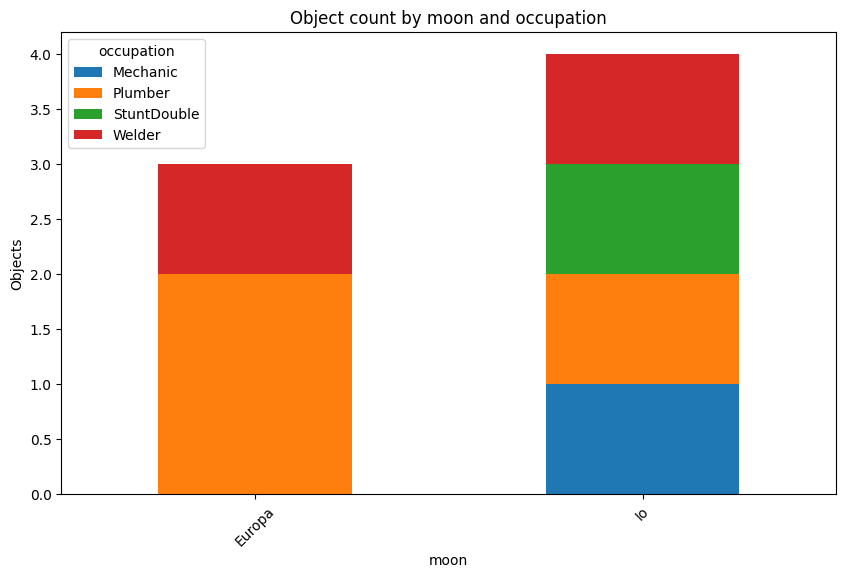

In [38]:
def plot_stacked_counts(pc, col1, col2):
    data_dict = pc.query_facets(facet_columns=[(col1, col2)])
    data_for_df = []
    for pair, values in data_dict.items():
        for v1, v2, count in values:
            data_for_df.append({
                col1: v1,
                col2: v2,
                'Count': count
            })
    df = pd.DataFrame(data_for_df)
    df_pivoted = df.pivot_table(index=col1, columns=col2, values='Count', fill_value=0)
    df_pivoted.plot(kind='bar', stacked=True, figsize=(10, 6))
    plt.title(f'Object count by {col1} and {col2}')
    plt.xlabel(col1)
    plt.ylabel('Objects')
    plt.xticks(rotation=45)
    plt.legend(title=col2)
    plt.show()
    
plot_stacked_counts(pc, "moon", "occupation")

## Complex objects

We can also store complex objects with arbitrary levels of nesting.

For the duckdb adapter, we explicitly do not use the standard linkml relmodel transform; instead we put
top level objects in individual collections, and behind the scenes duckdb will use lists and json objects for nesting, rather than rewriting these to normalized tables.

Here we will create a top level json objects that lists persons and organizations. Persons can have histories that are lists of event objects:

In [39]:
obj = {
        "persons": [
            {"id": 1, "name": "n1", "history": [
                {"event": "birth", "date": "2021-01-01"},
                {"event": "death", "date": "2021-02-01"},
                {"event": "hired", "date": "2021-02-01", "organization": "Org1"},
            ]},
            {"id": 2, "name": "n2", "age_in_years": 30},
        ],
        "organizations": [
            {"id": "Org1", "name": "org1"},
            {"id": "Org2", "name": "org2", "found_date": "2021-01-01"},
        ],
    }


In [40]:
db = client.attach_database("duckdb", "complex")

In [41]:
db.store(obj)

In [42]:
db.get_collection("persons").find().rows_dataframe

,age_in_years,history,id,name
0,NaN,"[{'event': 'birth', 'date': '2021-01-01'}, {'e...",1,n1
1,30.0,None,2,n2


## Schemas

Every Database has a **schema**. These can be provided explicitly via a LinkML specification,
or they can be *induced* from data.

In the first example, the schema is induced. We can query it:

In [43]:
from linkml_runtime.dumpers import yaml_dumper
print(yaml_dumper.dumps(pc.class_definition()))

name: Person
from_schema: http://example.org/test-schema
attributes:
  id:
    name: id
    from_schema: http://example.org/test-schema
    domain_of:
    - Person
    range: string
    multivalued: false
    inlined: false
  name:
    name: name
    from_schema: http://example.org/test-schema
    domain_of:
    - Person
    range: string
    multivalued: false
    inlined: false
  occupation:
    name: occupation
    from_schema: http://example.org/test-schema
    domain_of:
    - Person
    range: string
    multivalued: false
    inlined: false
  moon:
    name: moon
    from_schema: http://example.org/test-schema
    domain_of:
    - Person
    range: string
    multivalued: false
    inlined: false


## Asserting schemas

Inducing schemas is useful for quick operations but in general you are better specifying a schema up-front. This makes things more explicit, and in future can be used to do things like validate at time of insertion.

__TODO__

## Other adapters

__TODO__

## Indexing



In [44]:
from linkml_store.utils.format_utils import load_objects

COUNTRIES = "../../tests/input/countries/countries.jsonl"
objects = load_objects(COUNTRIES)

In [45]:
db = client.attach_database("duckdb", "CountryDB")
collection = db.create_collection("Country", alias="countries")

In [46]:
collection.insert(objects)

In [47]:
collection.query_facets(facet_columns=["continent"])

{'continent': [('Asia', 5),
  ('Europe', 5),
  ('Africa', 3),
  ('North America', 3),
  ('Oceania', 2),
  ('South America', 2)]}

In [48]:
collection.attach_indexer("simple")

In [49]:
sr = collection.search("Countries in the North that speak english and french")

In [50]:
sr.rows_dataframe

,score,name,code,capital,continent,languages
0,0.151858,Canada,CA,Ottawa,North America,"[English, French]"
1,0.139609,United States,US,"Washington, D.C.",North America,[English]
2,0.128295,South Africa,ZA,Pretoria,Africa,"[Zulu, Xhosa, Afrikaans, English, Northern Sot..."
3,0.101139,United Kingdom,GB,London,Europe,[English]
4,0.096154,Mexico,MX,Mexico City,North America,[Spanish]
5,0.095924,New Zealand,NZ,Wellington,Oceania,"[English, Māori]"
6,0.091025,France,FR,Paris,Europe,[French]
7,0.087383,Argentina,AR,Buenos Aires,South America,[Spanish]
8,0.079243,Australia,AU,Canberra,Oceania,[English]
9,0.077674,Brazil,BR,Brasília,South America,[Portuguese]
